# Homework 5: Deformation of a Clamped Thin Beam Using a Plate Model
MAE 263F - Fall 2025

This notebook simulates the static deformation of a thin, rectangular beam under gravity using the discrete plate model.

## Load Libraries

In [573]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Helper Functions

In [574]:
def signedAngle(u=None, v=None, n=None):
    """Calculate signed angle between two vectors u and v with respect to axis n."""
    w = np.cross(u, v)
    angle = np.arctan2(np.linalg.norm(w), np.dot(u, v))
    if np.dot(n, w) < 0:
        angle = -angle
    return angle

def mmt(matrix):
    """Return matrix + matrix.T"""
    return matrix + matrix.T

## Hinge Angle Functions

In [575]:
def getTheta(x0, x1=None, x2=None, x3=None):
    """Compute the hinge angle between two triangular faces."""
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0

    n0 = np.cross(m_e0, m_e1)
    n1 = np.cross(m_e2, m_e0)

    theta = signedAngle(n0, n1, m_e0)
    return theta

In [576]:
def gradTheta(x0, x1=None, x2=None, x3=None):
    """Compute the gradient of the hinge angle."""
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0
    m_e3 = x2 - x1
    m_e4 = x3 - x1

    m_cosA1 = np.dot(m_e0, m_e1) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_cosA2 = np.dot(m_e0, m_e2) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_cosA3 = -np.dot(m_e0, m_e3) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_cosA4 = -np.dot(m_e0, m_e4) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_sinA1 = np.linalg.norm(np.cross(m_e0, m_e1)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_sinA2 = np.linalg.norm(np.cross(m_e0, m_e2)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_sinA3 = -np.linalg.norm(np.cross(m_e0, m_e3)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_sinA4 = -np.linalg.norm(np.cross(m_e0, m_e4)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_nn1 = np.cross(m_e0, m_e3)
    m_nn1 = m_nn1 / np.linalg.norm(m_nn1)
    m_nn2 = -np.cross(m_e0, m_e4)
    m_nn2 = m_nn2 / np.linalg.norm(m_nn2)

    m_h1 = np.linalg.norm(m_e0) * m_sinA1
    m_h2 = np.linalg.norm(m_e0) * m_sinA2
    m_h3 = -np.linalg.norm(m_e0) * m_sinA3
    m_h4 = -np.linalg.norm(m_e0) * m_sinA4
    m_h01 = np.linalg.norm(m_e1) * m_sinA1
    m_h02 = np.linalg.norm(m_e2) * m_sinA2

    gradTheta = np.zeros(12)
    gradTheta[0:3] = m_cosA3 * m_nn1 / m_h3 + m_cosA4 * m_nn2 / m_h4
    gradTheta[3:6] = m_cosA1 * m_nn1 / m_h1 + m_cosA2 * m_nn2 / m_h2
    gradTheta[6:9] = -m_nn1 / m_h01
    gradTheta[9:12] = -m_nn2 / m_h02

    return gradTheta

In [577]:
def hessTheta(x0, x1=None, x2=None, x3=None):
    """Compute the Hessian of the hinge angle."""
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0
    m_e3 = x2 - x1
    m_e4 = x3 - x1

    m_cosA1 = np.dot(m_e0, m_e1) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_cosA2 = np.dot(m_e0, m_e2) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_cosA3 = -np.dot(m_e0, m_e3) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_cosA4 = -np.dot(m_e0, m_e4) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_sinA1 = np.linalg.norm(np.cross(m_e0, m_e1)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_sinA2 = np.linalg.norm(np.cross(m_e0, m_e2)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_sinA3 = -np.linalg.norm(np.cross(m_e0, m_e3)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_sinA4 = -np.linalg.norm(np.cross(m_e0, m_e4)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_nn1 = np.cross(m_e0, m_e3)
    m_nn1 /= np.linalg.norm(m_nn1)
    m_nn2 = -np.cross(m_e0, m_e4)
    m_nn2 /= np.linalg.norm(m_nn2)

    m_h1 = np.linalg.norm(m_e0) * m_sinA1
    m_h2 = np.linalg.norm(m_e0) * m_sinA2
    m_h3 = -np.linalg.norm(m_e0) * m_sinA3
    m_h4 = -np.linalg.norm(m_e0) * m_sinA4
    m_h01 = np.linalg.norm(m_e1) * m_sinA1
    m_h02 = np.linalg.norm(m_e2) * m_sinA2

    grad_theta = np.zeros((12, 1))
    grad_theta[0:3] = (m_cosA3 * m_nn1 / m_h3 + m_cosA4 * m_nn2 / m_h4).reshape(-1, 1)
    grad_theta[3:6] = (m_cosA1 * m_nn1 / m_h1 + m_cosA2 * m_nn2 / m_h2).reshape(-1, 1)
    grad_theta[6:9] = (-m_nn1 / m_h01).reshape(-1, 1)
    grad_theta[9:12] = (-m_nn2 / m_h02).reshape(-1, 1)

    m_m1 = np.cross(m_nn1, m_e1) / np.linalg.norm(m_e1)
    m_m2 = -np.cross(m_nn2, m_e2) / np.linalg.norm(m_e2)
    m_m3 = -np.cross(m_nn1, m_e3) / np.linalg.norm(m_e3)
    m_m4 = np.cross(m_nn2, m_e4) / np.linalg.norm(m_e4)
    m_m01 = -np.cross(m_nn1, m_e0) / np.linalg.norm(m_e0)
    m_m02 = np.cross(m_nn2, m_e0) / np.linalg.norm(m_e0)

    M331 = m_cosA3 / (m_h3 ** 2) * np.outer(m_m3, m_nn1)
    M311 = m_cosA3 / (m_h3 * m_h1) * np.outer(m_m1, m_nn1)
    M131 = m_cosA1 / (m_h1 * m_h3) * np.outer(m_m3, m_nn1)
    M3011 = m_cosA3 / (m_h3 * m_h01) * np.outer(m_m01, m_nn1)
    M111 = m_cosA1 / (m_h1 ** 2) * np.outer(m_m1, m_nn1)
    M1011 = m_cosA1 / (m_h1 * m_h01) * np.outer(m_m01, m_nn1)

    M442 = m_cosA4 / (m_h4 ** 2) * np.outer(m_m4, m_nn2)
    M422 = m_cosA4 / (m_h4 * m_h2) * np.outer(m_m2, m_nn2)
    M242 = m_cosA2 / (m_h2 * m_h4) * np.outer(m_m4, m_nn2)
    M4022 = m_cosA4 / (m_h4 * m_h02) * np.outer(m_m02, m_nn2)
    M222 = m_cosA2 / (m_h2 ** 2) * np.outer(m_m2, m_nn2)
    M2022 = m_cosA2 / (m_h2 * m_h02) * np.outer(m_m02, m_nn2)

    B1 = 1 / np.linalg.norm(m_e0) ** 2 * np.outer(m_nn1, m_m01)
    B2 = 1 / np.linalg.norm(m_e0) ** 2 * np.outer(m_nn2, m_m02)

    N13 = 1 / (m_h01 * m_h3) * np.outer(m_nn1, m_m3)
    N24 = 1 / (m_h02 * m_h4) * np.outer(m_nn2, m_m4)
    N11 = 1 / (m_h01 * m_h1) * np.outer(m_nn1, m_m1)
    N22 = 1 / (m_h02 * m_h2) * np.outer(m_nn2, m_m2)
    N101 = 1 / (m_h01 ** 2) * np.outer(m_nn1, m_m01)
    N202 = 1 / (m_h02 ** 2) * np.outer(m_nn2, m_m02)

    hess_theta = np.zeros((12, 12))

    hess_theta[0:3, 0:3] = mmt(M331) - B1 + mmt(M442) - B2
    hess_theta[0:3, 3:6] = M311 + M131.T + B1 + M422 + M242.T + B2
    hess_theta[0:3, 6:9] = M3011 - N13
    hess_theta[0:3, 9:12] = M4022 - N24
    hess_theta[3:6, 3:6] = mmt(M111) - B1 + mmt(M222) - B2
    hess_theta[3:6, 6:9] = M1011 - N11
    hess_theta[3:6, 9:12] = M2022 - N22
    hess_theta[6:9, 6:9] = -mmt(N101)
    hess_theta[9:12, 9:12] = -mmt(N202)

    hess_theta[3:6, 0:3] = hess_theta[0:3, 3:6].T
    hess_theta[6:9, 0:3] = hess_theta[0:3, 6:9].T
    hess_theta[9:12, 0:3] = hess_theta[0:3, 9:12].T
    hess_theta[6:9, 3:6] = hess_theta[3:6, 6:9].T
    hess_theta[9:12, 3:6] = hess_theta[3:6, 9:12].T

    return hess_theta

## Stretching Energy

In [578]:
def gradEs_hessEs(node0=None, node1=None, l_k=None, EA=None):
    """Compute gradient and Hessian of stretching energy."""
    edge = node1 - node0
    edgeLen = np.linalg.norm(edge)
    tangent = edge / edgeLen
    epsX = edgeLen / l_k - 1
    dF_unit = EA * tangent * epsX
    dF = np.zeros(6)
    dF[0:3] = -dF_unit
    dF[3:6] = dF_unit

    Id3 = np.eye(3)
    M = EA * ((1 / l_k - 1 / edgeLen) * Id3 + 1 / edgeLen * (np.outer(edge, edge)) / edgeLen ** 2)

    dJ = np.zeros((6, 6))
    dJ[0:3, 0:3] = M
    dJ[3:6, 3:6] = M
    dJ[0:3, 3:6] = -M
    dJ[3:6, 0:3] = -M
    return dF, dJ

## Bending Energy

In [579]:
def gradEb_hessEb_Shell(x0, x1=None, x2=None, x3=None, theta_bar=0, kb=1.0):
    """Compute gradient and Hessian of bending energy."""
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[:3]

    theta = getTheta(x0, x1, x2, x3)
    grad = gradTheta(x0, x1, x2, x3)

    dF = 0.5 * kb * (2 * (theta - theta_bar) * grad)

    hess = hessTheta(x0, x1, x2, x3)
    dJ = 0.5 * kb * (2 * np.outer(grad, grad) + 2 * (theta - theta_bar) * hess)

    return dF, dJ

## Visualization Functions

In [580]:
def set_axes_equal(ax):
    """Set equal aspect ratio for 3D plot."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

In [581]:
def plotPlate(qCurrent, edges, nv_x, nv_y, ctime, fixedNodes, hinges):
    """Plot the plate mesh in 3D."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    clear_output()

    # Highlight the hinges (shared edges) in green
    for hinge in hinges:
        node0, node1 = hinge[0], hinge[1]
        x0 = qCurrent[3*node0:3*node0+3]
        x1 = qCurrent[3*node1:3*node1+3]
        ax.plot3D([x0[0], x1[0]], [x0[1], x1[1]], [x0[2], x1[2]], 
                  color='g', linestyle='-', linewidth=2.0)

    # Plot all edges
    for edge in edges:
        node0, node1 = edge
        x0 = qCurrent[3*node0:3*node0+3]
        x1 = qCurrent[3*node1:3*node1+3]
        ax.plot3D([x0[0], x1[0]], [x0[1], x1[1]], [x0[2], x1[2]], 'k-', linewidth=0.5)

    # Plot nodes
    for i in range(nv_x * nv_y):
        node = qCurrent[3*i:3*i+3]
        if i in fixedNodes:
            ax.plot3D([node[0]], [node[1]], [node[2]], 'ro', markersize=8)  # Fixed nodes in red
        else:
            ax.plot3D([node[0]], [node[1]], [node[2]], 'bo', markersize=6)  # Free nodes in blue

    ax.set_title(f't = {ctime:.3f} s')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_zlabel('z [m]')
    set_axes_equal(ax)
    plt.tight_layout()
    return fig

## Objective Function (Newton-Raphson Solver)

In [582]:
def objfun(qOld, uOld, freeIndex, dt, tol, massVector, massMatrix,
           ks, refLen, edges,
           kb, thetaBar, hinges,
           Fg, visc):

  qNew = qOld.copy()
  ndof = len(qOld) # Number of DOFs

  iter = 0 # number of iteration
  error = 10 * tol
  # Newton Raphson
  while error > tol:

    # Bending force and jacobian
    Fb = np.zeros( ndof )
    Jb = np.zeros( (ndof,ndof) )
    # Loop over every "bending spring" or "hinge"
    for kHinge in range(hinges.shape[0]):
      node0 = hinges[kHinge, 0]
      node1 = hinges[kHinge, 1]
      node2 = hinges[kHinge, 2]
      node3 = hinges[kHinge, 3]
      x0 = qNew[ 3*node0: 3*node0 + 3]
      x1 = qNew[ 3*node1: 3*node1 + 3]
      x2 = qNew[ 3*node2: 3*node2 + 3]
      x3 = qNew[ 3*node3: 3*node3 + 3]
      ind = [3*node0, 3*node0 + 1, 3*node0 + 2,
             3*node1, 3*node1 + 1, 3*node1 + 2,
             3*node2, 3*node2 + 1, 3*node2 + 2,
             3*node3, 3*node3 + 1, 3*node3 + 2]
      dF, dJ = gradEb_hessEb_Shell(x0, x1, x2, x3, 0, kb)
      Fb[ind] -= dF
      Jb[np.ix_(ind,ind)] -= dJ

    # Stretching force and jacobian
    Fs = np.zeros( ndof )
    Js = np.zeros( (ndof,ndof) )
    for kEdge in range(edges.shape[0]):
      node0 = edges[kEdge, 0]
      node1 = edges[kEdge, 1]
      x0 = qNew[ 3*node0: 3*node0 + 3]
      x1 = qNew[ 3*node1: 3*node1 + 3]
      ind = [3*node0, 3*node0 + 1, 3*node0 + 2,
             3*node1, 3*node1 + 1, 3*node1 + 2]
      dF, dJ = gradEs_hessEs(x0, x1, refLen[kEdge], ks[kEdge])
      Fs[ind] -= dF
      Js[np.ix_(ind,ind)] -= dJ

    # Viscous force
    Fv = - visc * (qNew - qOld) / dt
    Jv = - visc / dt * np.eye(ndof)

    Forces = Fb + Fs + Fg + Fv # Sum of forces
    JForces = Jb + Js + Jv # Sum of Jacobians

    # Set up my equations of motion and calculating its residual (=0)
    f = massVector / dt * ( (qNew - qOld)/dt - uOld) - Forces # Residual of EOM
    J = massMatrix / dt ** 2 - JForces

    # Extract the free part of the f and J arrays
    f_free = f[freeIndex]
    J_free = J[np.ix_(freeIndex, freeIndex)]
    # Correction
    dq_free = np.linalg.solve(J_free, f_free)

    # Update my guess for position
    qNew[freeIndex] -= dq_free

    # Calculate error
    error = np.sum( np.abs(f_free))

    iter += 1

    print('Iter = ', iter, ' error=', error)

  uNew = (qNew - qOld) / dt
  return qNew, uNew

## Problem Setup

### Geometry Parameters

In [583]:
# Beam dimensions
l = 0.1  # length in m
w = 0.01  # width in m
h = 0.002  # thickness in m

# Material properties
Y = 1.0e7  # Young's modulus in Pa
rho = 1000  # density in kg/m^3
g = 9.8  # gravity in m/s^2

# Cross-sectional properties
A = w * h  # cross-sectional area
I = w * h**3 / 12  # second moment of area

# Distributed load
q = rho * A * g  # load per unit length

print(f"Beam dimensions: L = {l} m, w = {w} m, h = {h} m")
print(f"Material: Y = {Y} Pa, rho = {rho} kg/m^3")
print(f"Cross-section: A = {A} m^2, I = {I} m^4")
print(f"Distributed load: q = {q} N/m")

Beam dimensions: L = 0.1 m, w = 0.01 m, h = 0.002 m
Material: Y = 10000000.0 Pa, rho = 1000 kg/m^3
Cross-section: A = 2e-05 m^2, I = 6.666666666666667e-12 m^4
Distributed load: q = 0.196 N/m


### Euler-Bernoulli Prediction

In [584]:
# Euler-Bernoulli tip displacement (negative because it's downward)
delta_EB = -(q * l**4) / (8 * Y * I)
print(f"Euler-Bernoulli predicted tip displacement: δ_EB = {delta_EB:.6e} m ({delta_EB*1000:.2f} mm)")

Euler-Bernoulli predicted tip displacement: δ_EB = -3.675000e-02 m (-36.75 mm)


### Create Mesh

In [585]:
# Mesh parameters (2 rows x 10 columns as specified in homework)
nv_x = 10  # number of nodes in x-direction (including extra clamped column at x = -dx)
nv_y = 2   # number of nodes in y-direction
nv = nv_x * nv_y  # total number of nodes
ndof = 3 * nv     # total degrees of freedom

# Node spacing
# Free length l is between x = 0 and x = l, with nv_x - 1 nodes there => (nv_x - 2) intervals
dx = l / (nv_x - 2)          # -> 0.1 / 8 = 0.0125 m
dy = w / (nv_y - 1)          # -> 0.01 / 1 = 0.01 m

# Create initial node positions
qOld = np.zeros(ndof)
for i in range(nv_x):
    for j in range(nv_y):
        node_idx = i * nv_y + j
        qOld[3 * node_idx]     = i * dx - dx   # x-coordinate: -dx, 0, dx, ..., 8dx=l
        qOld[3 * node_idx + 1] = j * dy        # y-coordinate: 0 or 0.01
        qOld[3 * node_idx + 2] = 0.0           # z-coordinate

print(f"Mesh: {nv_x} x {nv_y} = {nv} nodes")
print(f"Node spacing: dx = {dx} m, dy = {dy} m")


Mesh: 10 x 2 = 20 nodes
Node spacing: dx = 0.0125 m, dy = 0.01 m


### Define Connectivity (Edges and Hinges)

In [586]:
# Create edges (stretching springs)
edges_list = []

# Horizontal edges
for i in range(nv_x - 1):
    for j in range(nv_y):
        node0 = i * nv_y + j
        node1 = (i + 1) * nv_y + j
        edges_list.append((node0, node1))

# Vertical edges
for i in range(nv_x):
    for j in range(nv_y - 1):
        node0 = i * nv_y + j
        node1 = i * nv_y + (j + 1)
        edges_list.append((node0, node1))

# Diagonal edges - ZIGZAG PATTERN (one diagonal per square)
for i in range(nv_x - 1):
    for j in range(nv_y - 1):
        
        # 1. Define the four corner indices of the current quadrilateral element
        k_BL = i * nv_y + j           # Bottom-Left
        k_BR = (i + 1) * nv_y + j     # Bottom-Right
        k_TL = i * nv_y + (j + 1)     # Top-Left
        k_TR = (i + 1) * nv_y + (j + 1) # Top-Right

        # 2. Alternate diagonal direction based on checkerboard pattern (i + j)
        if (i + j) % 2 == 0:
            # Diagonal 1: Top-Left to Bottom-Right ( \ )
            edges_list.append((k_TL, k_BR))
        else:
            # Diagonal 2: Bottom-Left to Top-Right ( / )
            edges_list.append((k_BL, k_TR))

edges = np.array(edges_list)
print(f"Number of edges: {len(edges)}")

# Create hinges (bending springs)
# A hinge connects 4 nodes: node0-node1 is the shared edge, node2 and node3 are opposite vertices
hinges_list = []

# 1. Diagonal hinges (original - along diagonals within each square)
'''for i in range(nv_x - 1):
    for j in range(nv_y - 1):
        node0 = i * nv_y + j
        node1 = (i + 1) * nv_y + (j + 1)
        node2 = i * nv_y + (j + 1)
        node3 = (i + 1) * nv_y + j
        hinges_list.append((node0, node1, node2, node3))'''

for i in range(nv_x - 1):
    for j in range(nv_y - 1):
        # 1. Define the four corner nodes of the current square
        k_BL = i * nv_y + j           # Bottom-Left
        k_BR = (i + 1) * nv_y + j     # Bottom-Right
        k_TL = i * nv_y + (j + 1)     # Top-Left
        k_TR = (i + 1) * nv_y + (j + 1) # Top-Right

        if (i + j) % 2 == 0:
            # Diagonal was Top-Left (TL) to Bottom-Right (BR)
            # The Hinge Axis is the diagonal: TL - BR
            # The "Wing" nodes are the other two: BL and TR
            hinges_list.append([k_TL, k_BR, k_BL, k_TR])
        else:
            # Diagonal was Bottom-Left (BL) to Top-Right (TR)
            # The Hinge Axis is the diagonal: BL - TR
            # The "Wing" nodes are the other two: BR and TL
            hinges_list.append([k_BL, k_TR, k_BR, k_TL])


# 2. Vertical edge hinges (along shared vertical edges between horizontally adjacent squares)
# Grid looks like: nv_x columns, nv_y rows, with squares formed between adjacent columns
# Each internal vertical edge is shared by two triangles (from adjacent squares)
for i in range(1, nv_x - 1):  # Internal columns only
    for j in range(nv_y - 1):  # Each vertical edge
        # Vertical edge from (i, j) to (i, j+1)
        # Left triangle vertices: depends on diagonal direction of left square
        # Right triangle vertices: depends on diagonal direction of right square
        left_i = i - 1
        right_i = i
        
        # Shared edge nodes
        edge_node0 = i * nv_y + j
        edge_node1 = i * nv_y + (j + 1)
        
        # Find opposite vertices from left and right squares
        # Left square is at (left_i, j)
        if (left_i + j) % 2 == 0:
            # Left square has top-left to bottom-right diagonal
            # Triangle sharing this vertical edge has vertices: edge_node0, edge_node1, and bottom-left OR top-left
            opposite_left = left_i * nv_y + j  # bottom-left of left square
        else:
            # Left square has bottom-left to top-right diagonal
            opposite_left = left_i * nv_y + (j + 1)  # top-left of left square
        
        # Right square is at (right_i, j)
        if (right_i + j) % 2 == 0:
            # Right square has top-left to bottom-right diagonal
            opposite_right = (right_i + 1) * nv_y + j  # bottom-right of right square
        else:
            # Right square has bottom-left to top-right diagonal
            opposite_right = (right_i + 1) * nv_y + (j + 1)  # top-right of right square
        
        hinges_list.append((edge_node0, edge_node1, opposite_left, opposite_right))

# 3. Horizontal edge hinges (along shared horizontal edges between vertically adjacent squares)
# Since we only have 2 rows (nv_y = 2), we only have one horizontal edge per column
for i in range(nv_x - 1):  # Each square column
    # Horizontal edge at j = 0 or j = 1 depending on which is internal
    # For nv_y = 2, we have j = 0 (bottom) and j = 1 (top)
    # The horizontal edge between them is at the same i position
    # But with only 1 row of squares, there's no "between" - skip this
    pass  # No horizontal hinges needed for nv_y = 2

hinges = np.array(hinges_list)
print(f"Number of hinges: {len(hinges)} (9 diagonal + {len(hinges_list) - 9} edge hinges)")

Number of edges: 37
Number of hinges: 17 (9 diagonal + 8 edge hinges)


### Elastic Stiffness

In [587]:
Y = 1.0e7 # Young's modulus in Pa
h = 0.002 # Thickness in meter

# Stiffness variables
kb = 2.0 / np.sqrt(3.0) * Y * h**3.0 / 12 # Bending stiffness (Newton-meter)
refLen = np.zeros(edges.shape[0]) # reference length, denoted as l_k
ks = np.zeros_like(refLen) # Stretching stiffness
for kEdge in range(edges.shape[0]):
  node0 = edges[kEdge, 0]
  node1 = edges[kEdge, 1]
  x0 = qOld[ 3*node0: 3*node0 + 3]
  x1 = qOld[ 3*node1: 3*node1 + 3]
  refLen[kEdge] = np.linalg.norm(x1 - x0)
  ks[kEdge] = np.sqrt(3.0) / 2.0 * Y * h * (refLen[kEdge]) ** 2

print(f"Bending stiffness: kb = {kb:.6e} N·m")
print(f"Stretching stiffness range: [{ks.min():.6e}, {ks.max():.6e}] N")

Bending stiffness: kb = 7.698004e-03 N·m
Stretching stiffness range: [1.732051e+00, 4.438380e+00] N


### Natural Curvature

In [588]:
# Compute natural curvature (reference angles) for each hinge
# For a flat plate, getTheta returns 0 (coplanar triangular faces)
thetaBar = np.zeros(hinges.shape[0])
for kHinge in range(hinges.shape[0]):
    node0 = hinges[kHinge, 0]
    node1 = hinges[kHinge, 1]
    node2 = hinges[kHinge, 2]
    node3 = hinges[kHinge, 3]
    x0 = qOld[3*node0:3*node0+3]
    x1 = qOld[3*node1:3*node1+3]
    x2 = qOld[3*node2:3*node2+3]
    x3 = qOld[3*node3:3*node3+3]
    thetaBar[kHinge] = getTheta(x0, x1, x2, x3)

print(f"Reference angles computed for {len(thetaBar)} hinges")
print(f"thetaBar values: {thetaBar}")

Reference angles computed for 17 hinges
thetaBar values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Time Parameters

In [589]:
totalTime = 20  # seconds (run until steady state)
dt = 0.001  # time step size
tol = kb / 0.01 * 1e-3  # tolerance
visc = 0  # Add damping to reach steady state

print(f"Total time: {totalTime} s")
print(f"Time step: {dt} s")
print(f"Tolerance: {tol:.6e}")
print(f"Viscosity: {visc}")

Total time: 20 s
Time step: 0.001 s
Tolerance: 7.698004e-04
Viscosity: 0


### Mass Distribution

In [590]:
# Total mass
totalM = rho * A * l
dm = totalM / nv  # mass per node
massVector = np.zeros(ndof)
for c in range(nv):
    ind = [3*c, 3*c+1, 3*c+2]
    massVector[ind] = dm
massMatrix = np.diag(massVector)

print(f"Total mass: {totalM:.6e} kg")
print(f"Mass per node: {dm:.6e} kg")

Total mass: 2.000000e-03 kg
Mass per node: 1.000000e-04 kg


### External Force (Gravity)

In [591]:
# Gravity vector
g_vec = np.array([0, 0, -g])

Fg = np.zeros(ndof)
for c in range(nv):
    ind = [3*c, 3*c+1, 3*c+2]
    Fg[ind] = massVector[ind] * g_vec

print(f"Gravity force applied to all nodes in -z direction")

Gravity force applied to all nodes in -z direction


### Boundary Conditions

In [592]:
# Fix the leftmost column (nv_y nodes at i=0)
fixedNodes = [0, 1, 2, 3]  # First column: 4 nodes as required by homework
fixedIndex = []
for node in fixedNodes:
    fixedIndex.extend([3*node, 3*node+1, 3*node+2])

fixedIndex = np.array(fixedIndex)
freeIndex = np.setdiff1d(np.arange(ndof), fixedIndex)

print(f"Fixed nodes: {fixedNodes}")
print(f"Free DOFs: {len(freeIndex)}")

Fixed nodes: [0, 1, 2, 3]
Free DOFs: 48


### Initial Conditions

In [593]:
# Initial velocity is zero
uOld = np.zeros(ndof)

# Store initial z-coordinate of tip (centerline at x = l)
# Tip is at node (nv_x-1, 0) for bottom and (nv_x-1, 1) for top
# We'll track the centerline, which is the average
tip_node_bottom = (nv_x - 1) * nv_y + 0
tip_node_top = (nv_x - 1) * nv_y + 1
z_tip_initial = (qOld[3*tip_node_bottom + 2] + qOld[3*tip_node_top + 2]) / 2

print(f"Initial tip z-coordinate: {z_tip_initial} m")

Initial tip z-coordinate: 0.0 m


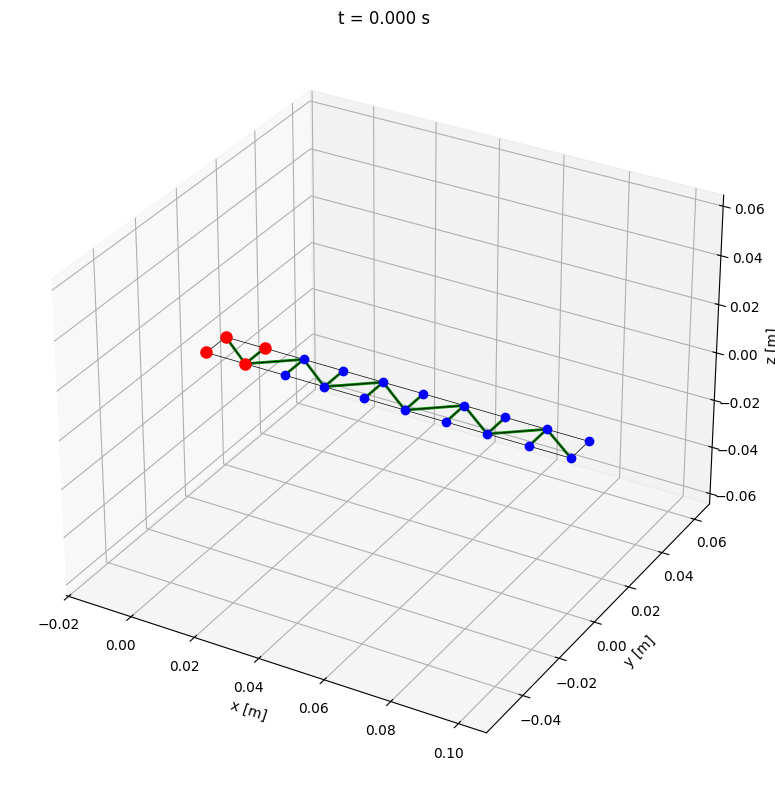

In [594]:
fig = plotPlate(qOld, edges, nv_x, nv_y, 0, fixedNodes, hinges_list)
plt.show()

## Time-Stepping Simulation

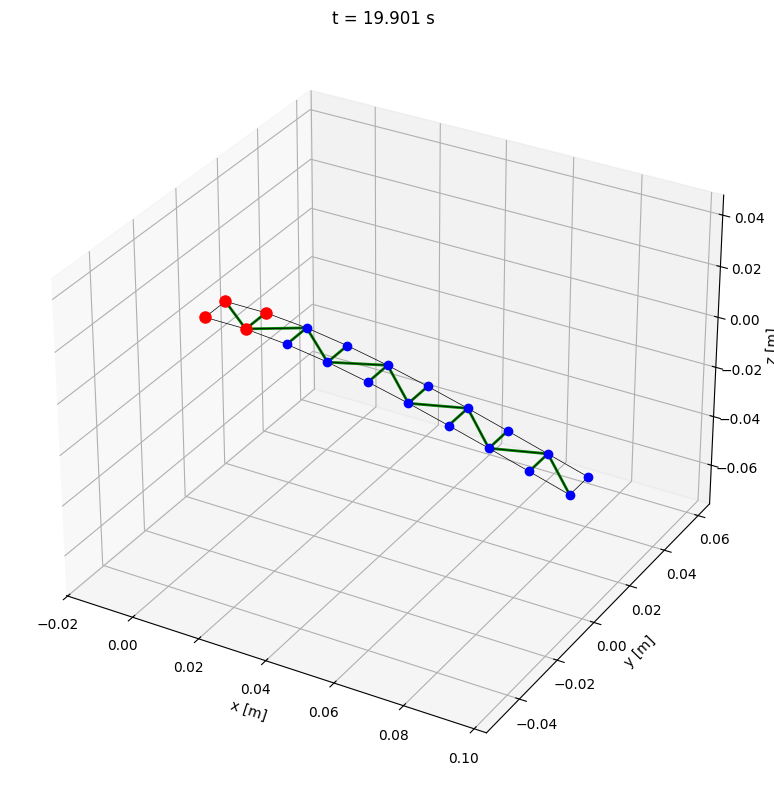

Iter =  1  error= 0.0019384757049717596
Iter =  2  error= 1.3201102888869231e-08
Iter =  1  error= 0.0020074104410065185
Iter =  2  error= 1.4157246703579435e-08
Iter =  1  error= 0.0020752816703919945
Iter =  2  error= 1.513133584597842e-08
Iter =  1  error= 0.0021420552211230673
Iter =  2  error= 1.612129713869869e-08
Iter =  1  error= 0.002207697505422424
Iter =  2  error= 1.7125120427387283e-08
Iter =  1  error= 0.0022721755369612667
Iter =  2  error= 1.814069135040541e-08
Iter =  1  error= 0.0023354569476346943
Iter =  2  error= 1.9165886212895935e-08
Iter =  1  error= 0.002397510003799641
Iter =  2  error= 2.0198614665236897e-08
Iter =  1  error= 0.0024583036220952835
Iter =  2  error= 2.1236665743097325e-08
Iter =  1  error= 0.002517807384865421
Iter =  2  error= 2.22779631687098e-08
Iter =  1  error= 0.0025759915552368427
Iter =  2  error= 2.3320311486763513e-08
Iter =  1  error= 0.0026328270919020813
Iter =  2  error= 2.4361548122649347e-08
Iter =  1  error= 0.0026882856635955

In [595]:
Nsteps = round(totalTime / dt)
ctime = 0
delta_plate = np.zeros(Nsteps)  # Tip displacement over time
time_array = np.zeros(Nsteps)

print(f"Starting simulation with {Nsteps} time steps...\n")

for timeStep in range(Nsteps):
    if timeStep % 100 == 0:
        print(f"Time step {timeStep}/{Nsteps}, t = {ctime:.3f} s")
    
    # Solve for new configuration
    qNew, uNew = objfun(qOld, uOld, freeIndex, dt, tol, massVector, massMatrix,
                        ks, refLen, edges, kb, thetaBar, hinges, Fg, visc)
    
    ctime += dt
    
    # Update
    qOld = qNew.copy()
    uOld = uNew.copy()
    
    # Compute tip displacement
    z_tip_current = (qNew[3*tip_node_bottom + 2] + qNew[3*tip_node_top + 2]) / 2
    delta_plate[timeStep] = z_tip_current - z_tip_initial
    time_array[timeStep] = ctime

    if timeStep % 100 == 0:
        plotPlate(qOld, edges, nv_x, nv_y, ctime, fixedNodes, hinges_list)
        plt.show()

print(f"\nSimulation complete!")

## Results

### Steady-State Displacement

In [596]:
# Get steady-state displacement (average of last 10% of simulation)
steady_start = int(0.9 * Nsteps)
delta_plate_steady = np.mean(delta_plate[steady_start:])

# Compute normalized difference
normalized_diff = abs(delta_plate_steady - delta_EB) / abs(delta_EB)

print("="*60)
print("RESULTS")
print("="*60)
print(f"Euler-Bernoulli prediction:    δ_EB    = {delta_EB:.6e} m")
print(f"Plate simulation (steady):     δ_plate = {delta_plate_steady:.6e} m")
print(f"Normalized difference:         {normalized_diff:.6f} ({normalized_diff*100:.2f}%)")
print("="*60)

RESULTS
Euler-Bernoulli prediction:    δ_EB    = -3.675000e-02 m
Plate simulation (steady):     δ_plate = -2.821027e-02 m
Normalized difference:         0.232374 (23.24%)


### Plot: Tip Displacement vs Time

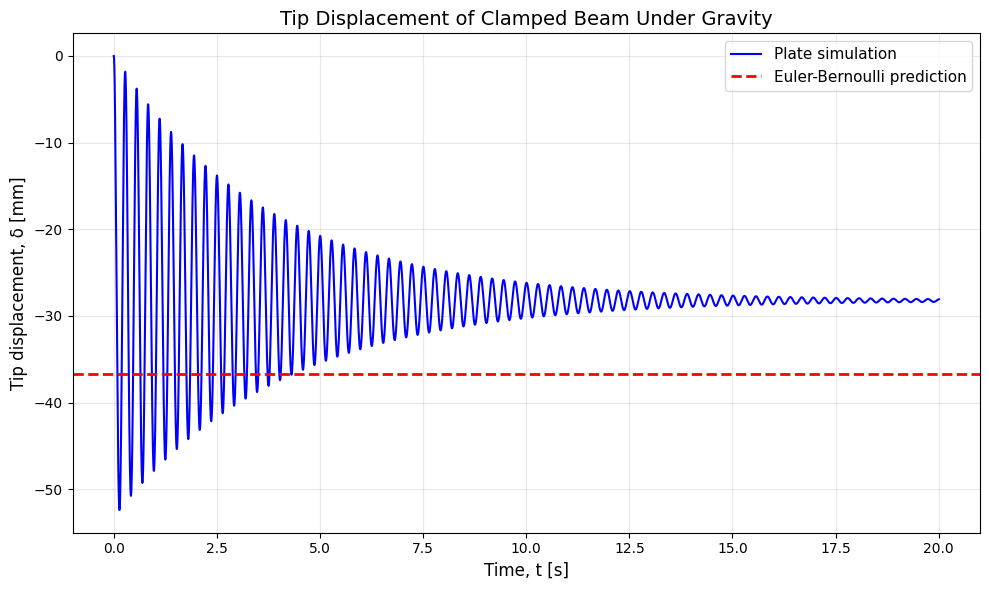

Figure 1: Tip displacement vs. time for the clamped beam simulation.


In [597]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_array, delta_plate * 1000, 'b-', linewidth=1.5, label='Plate simulation')
ax.axhline(y=delta_EB * 1000, color='r', linestyle='--', linewidth=2, label='Euler-Bernoulli prediction')
ax.set_xlabel('Time, t [s]', fontsize=12)
ax.set_ylabel('Tip displacement, δ [mm]', fontsize=12)
ax.set_title('Tip Displacement of Clamped Beam Under Gravity', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Figure 1: Tip displacement vs. time for the clamped beam simulation.")

### Plot: Final Deformed Configuration

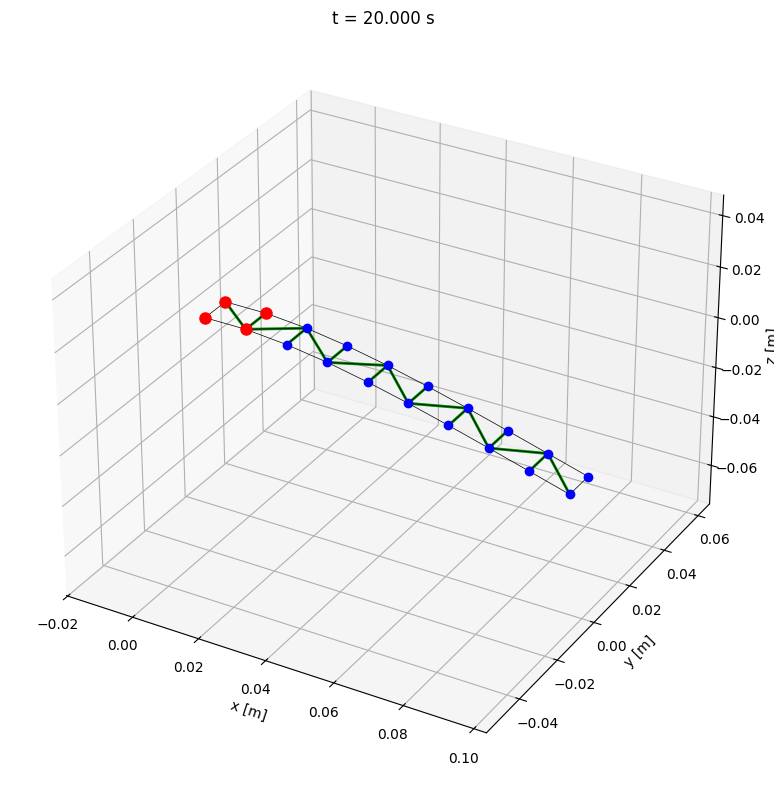

Figure 2: Final deformed configuration of the clamped beam (red = fixed nodes, blue = free nodes).


In [598]:
fig = plotPlate(qOld, edges, nv_x, nv_y, ctime, fixedNodes, hinges_list)
plt.show()

print("Figure 2: Final deformed configuration of the clamped beam (red = fixed nodes, blue = free nodes).")